# Resnet Internals and Lifecycle Visualization

In [1]:
import torch
import torchvision.models as models
from torchvision.models import resnet18
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cpu")

Matplotlib is building the font cache; this may take a moment.


In [2]:
model = resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 2)

model.load_state_dict(torch.load("model_archives/KaggleUltrasound/resnet_continual.pth", map_location=device))
model.eval()

print("Model loaded successfully")


Model loaded successfully


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


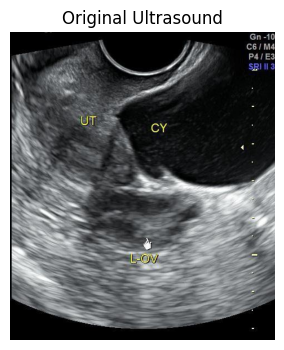

In [ ]:
# Recur same operations
img_path = "example/ultrasoung.JPG" # Random image

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

image = Image.open(img_path).convert("RGB")
input_image = transform(image).unsqueeze(0)

# Show original image
plt.figure(figsize=(4,4))
plt.imshow(image)
plt.title("Original Ultrasound")
plt.axis("off")
plt.show()

In [18]:
activations = {}  # model layer activations
residual_data = {}  # input streams

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

def hook_residual(name):
    def hook(module, input, output):

        x = input[0].detach()
        out = output.detach()

        # Some blocks change size → handle safely
        if x.shape == out.shape:
            residual = out - x
        else:
            residual = None

        residual_data[name] = {
            "input": x,
            "output": out,
            "residual": residual
        }

    return hook



# Activation hooks to see the patterns
model.layer1.register_forward_hook(get_activation("layer1"))
model.layer2.register_forward_hook(get_activation("layer2"))
model.layer3.register_forward_hook(get_activation("layer3"))
model.layer4.register_forward_hook(get_activation("layer4"))

print("Hooks registered on all the layers")


# Residual hooks → first block of each ResNet layer
# Residual hooks → ALL blocks of each ResNet layer
for layer_name in ["layer1", "layer2", "layer3", "layer4"]:

    layer = getattr(model, layer_name)

    for block_idx, block in enumerate(layer):

        hook_name = f"{layer_name}_block{block_idx+1}"
        block.register_forward_hook(hook_residual(hook_name))


print("Residual hooks registered on the inputs")

Hooks registered on all the layers
Residual hooks registered on the inputs


In [19]:
with torch.no_grad():
    output = model(input_image)
    probs = torch.softmax(output, dim=1)
    prediction = torch.argmax(probs).item()

if prediction == 1:
    print("Prediction: Cancer")
else:
    print("Prediction: Benign")

print("Confidence:", probs.numpy())

Prediction: Benign
Confidence: [[0.9981875  0.00181256]]


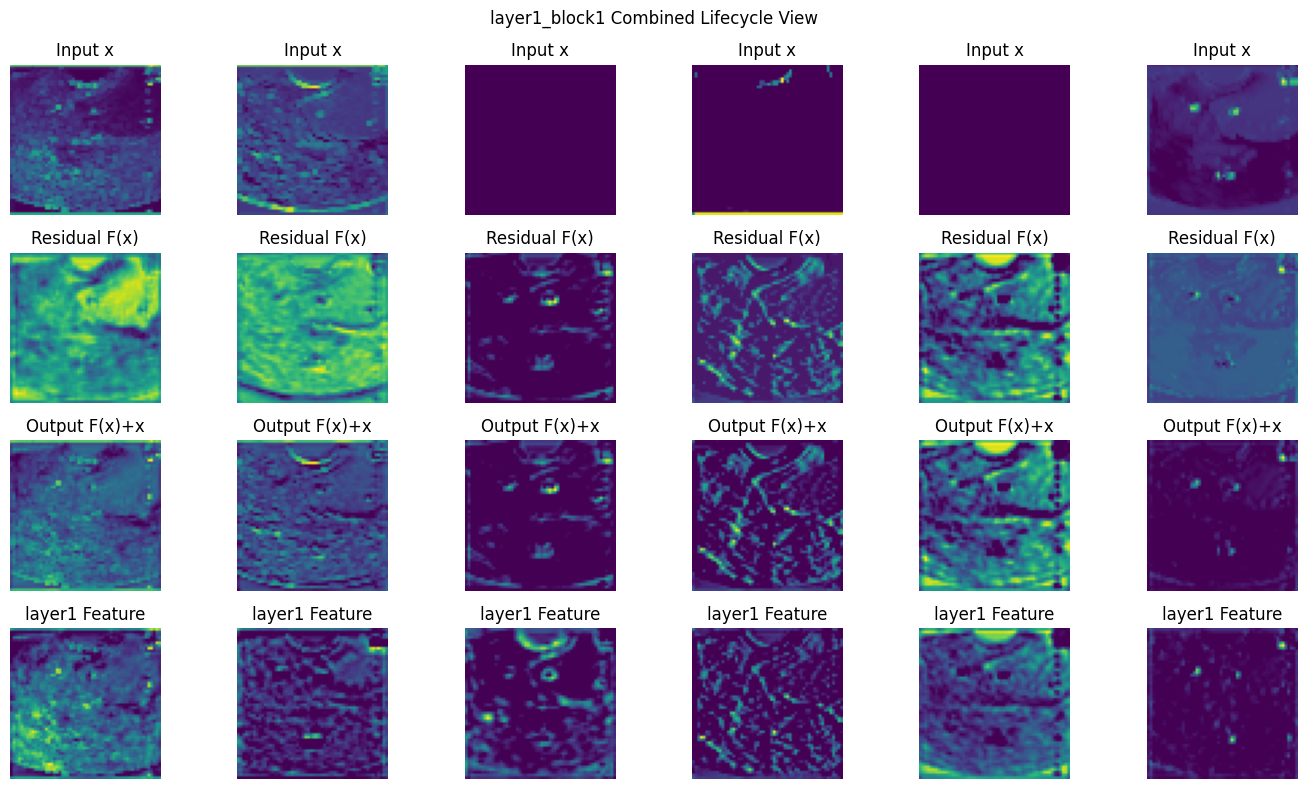

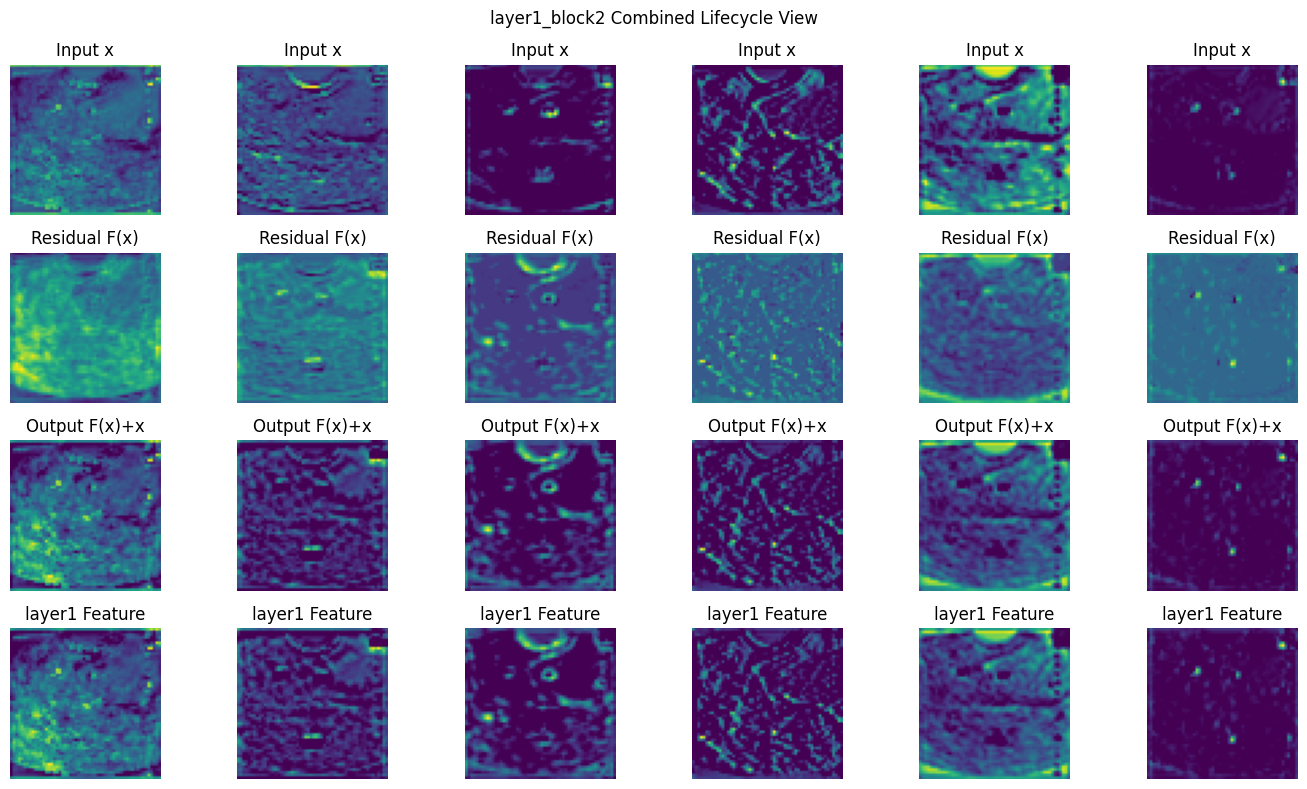

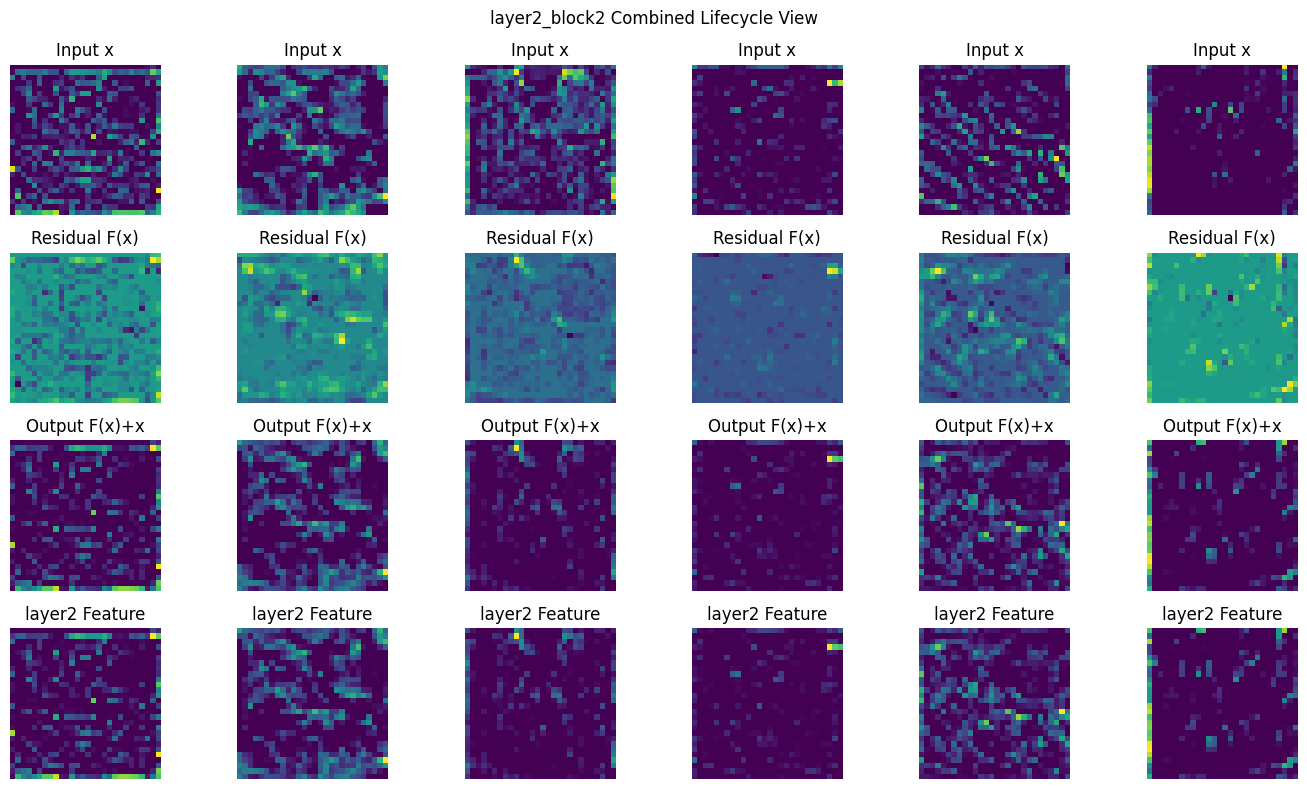

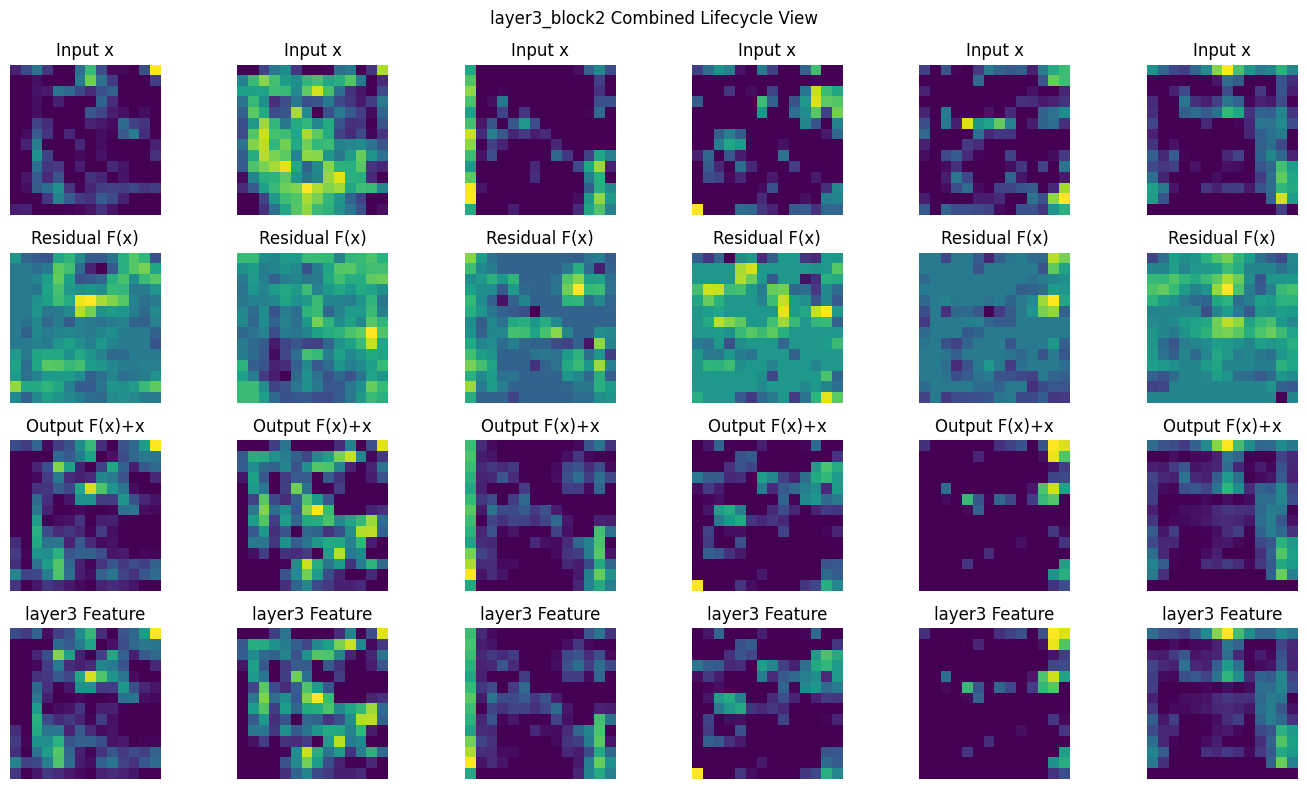

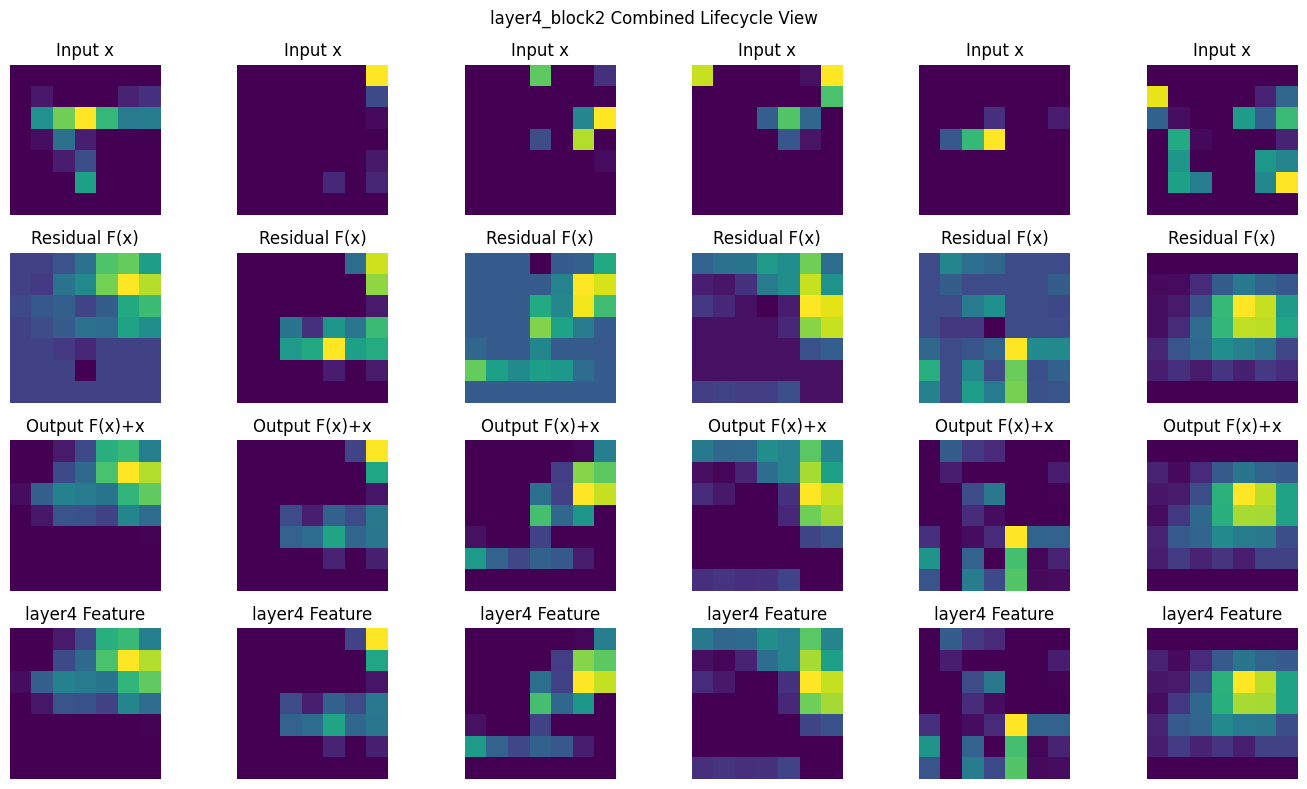

In [22]:
# ===== Combined Residual + Feature Map Visualization =====

for name, data in residual_data.items():

    # Extract layer name from block name
    layer_name = name.split("_")[0]

    # Skip if layer activation missing
    if layer_name not in activations:
        continue

    x = data["input"]
    out = data["output"]
    residual = data["residual"]
    act = activations[layer_name]

    if residual is None:
        continue

    num_maps = min(6, x.shape[1])

    fig, axes = plt.subplots(4, num_maps, figsize=(14,8))
    fig.suptitle(f"{name} Combined Lifecycle View")

    for i in range(num_maps):

        # ----- Input -----
        axes[0, i].imshow(x[0, i].cpu(), cmap="viridis")
        axes[0, i].set_title("Input x")
        axes[0, i].axis("off")

        # ----- Residual -----
        res_map = residual[0, i].cpu()
        res_map = (res_map - res_map.min()) / (res_map.max() - res_map.min() + 1e-5)

        axes[1, i].imshow(res_map, cmap="viridis")
        axes[1, i].set_title("Residual F(x)")
        axes[1, i].axis("off")

        # ----- Output -----
        axes[2, i].imshow(out[0, i].cpu(), cmap="viridis")
        axes[2, i].set_title("Output F(x)+x")
        axes[2, i].axis("off")

        # ----- Layer Feature Map -----
        axes[3, i].imshow(act[0, i].cpu(), cmap="viridis")
        axes[3, i].set_title(f"{layer_name} Feature")
        axes[3, i].axis("off")

    plt.tight_layout()
    plt.show()


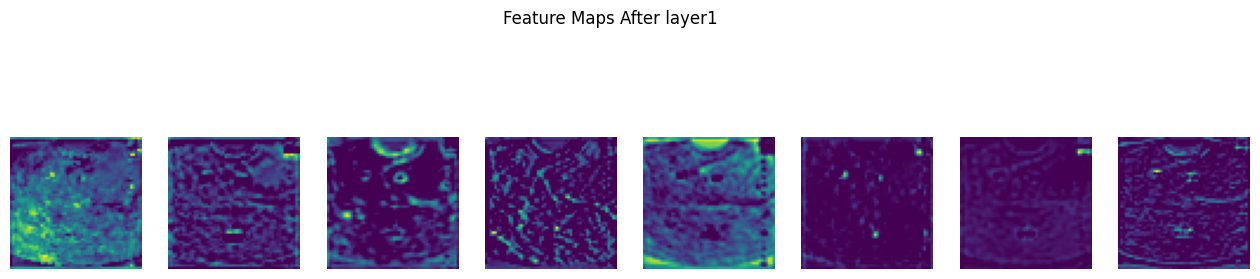

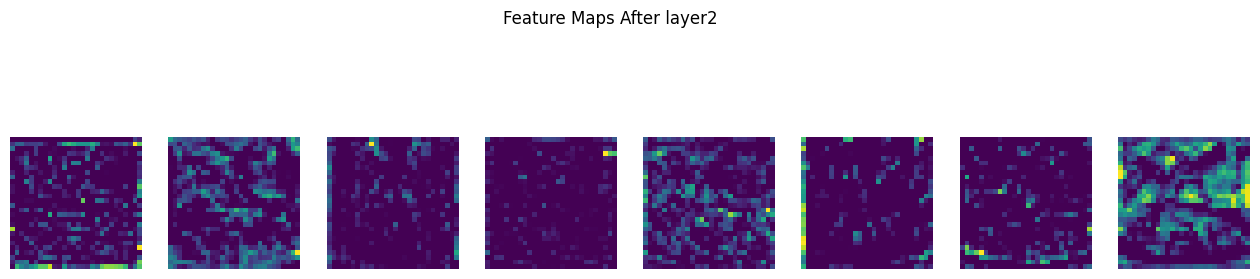

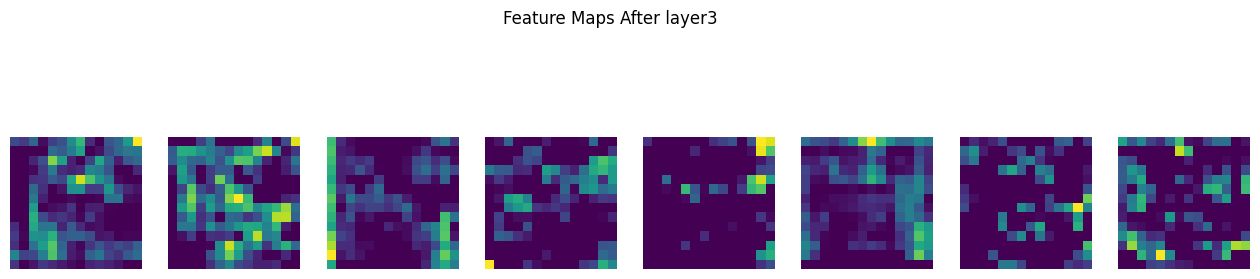

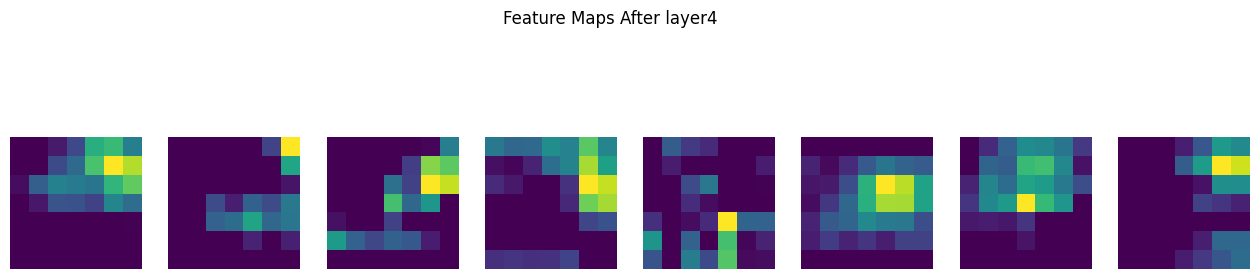

In [ ]:
# Simple activations
for name, act in activations.items():

    num_feature_maps = act.shape[1]

    fig, axes = plt.subplots(1, min(num_feature_maps, 8), figsize=(16,4))
    fig.suptitle(f"Feature Maps After {name}")

    for i in range(min(num_feature_maps, 8)):
        axes[i].imshow(act[0, i].cpu())
        axes[i].axis("off")

    plt.show()



## Finalized perspectives
A new layer is aded at the end which converts the 4th layer to a 0 or 1 neuron activation based detection, and the decreasing resolution makes resnet the best usecase model since its not just channel forwarding its residuals of the channel forwardins since we never wanna lose the initial data of the scan, this makes it the best neural network to use